# JSON UFrame Request with Real-time Updating

Adapted from Friedrick Knuth's [notebook](https://github.com/oceanhackweek/CAHW2018_Materials/blob/master/Tutorials/OOI_M2M_Interface_Tutorial/ooi_m2m_json/02_realtime_time_series_requests.ipynb) pre-yodapy.

With yodapy, it is also possible to cotinually update a dataset programmatically, showing the last n data points while data is available. For this example, we will again use the CTD instrument to plot dissolved oxygen. We begin with our usual imports and credential-setting.

In [1]:
from yodapy.utils import set_credentials_file
from yodapy.datasources import OOI

set_credentials_file(data_source="ooi",username="OOIAPI-CHN725DB03M3AC",token="SAFZTAB3M1")

In [2]:
ooi = OOI()
ooi.filter(region="cabled continental margin",site="Oregon Slope Base Shallow Profiler Mooring",instrument="RS01SLBS-LJ01A-12-CTDPFB101")
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1236,RS01SLBS-LJ01A-12-CTDPFB101,CTD,2924.0,2924.0,,ctdpf_optode_sample,908,Located Off Jbox


And a quick request just to establish what we are dealing with.

In [3]:
import datetime

start = (datetime.datetime.now() - datetime.timedelta(seconds = 5)).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.000Z")

data = ooi.request_data(
        begin_date=start,
        end_date=end,
        limit=20,
        data_type="json")

In [4]:
# just the first 5 samples, we will get to the heavy lifting later
# do for Dissolved Oxygen
do = [(d["dissolved_oxygen"],d["time"]) for d in data.raw()[0]["data"][-5:]]
do

[(86.2375041170931, 3740124779.3531437),
 (86.28791396927157, 3740124780.3530445),
 (86.26579313223992, 3740124781.3532586),
 (86.27937671521552, 3740124782.353995),
 (86.25967470706985, 3740124783.367336)]

## A Note on Timestamps

The above has been demonstrated several times already in other notebooks. What makes our problem unique is dealing with the timestamps coming in with the data. If we convert a datapoint from the above table into a readable date, we find our first issue.

In [5]:
import datetime

date = datetime.datetime.utcfromtimestamp(int(do[1][1])) # - datetime.timedelta(days = 365 * 70)
date

datetime.datetime(2088, 7, 8, 11, 33)

Using datetime objects with our data timestamp, we find that our data comes from 70 years in the future! And, given that the request was sent on July 9th, it is strange to see it appear as July 8th. This may seem like a problem at first, but it is really just a quirk of working with the OOI portal with Python. As long as we don't try to construct a date object without an external library from OOI data, this is a moot point. Our workflow with timestamps from OOI is to just pass them right back to the API as we concatenate more data.

## Create the Initial Dataset

For this demonstration, we want to see 20,000 data points at once and plot them as the set updates. Before we can get to the updating, we need to populate a table with the first 20,000. Adding these points as new data comes in would be horrifically slow (indeed, it would take around five and a half hours). So instead, we will look back in time until we find 20,000 points of data.

However, this presents a new challenge in that if we look too far back in time (i.e. over a time period with 22,000 points when we need 20,000), the data portal will discard some points to keep the request at a reasonable size. In our case, that harms the resolution of our second-by-second plot. Instead, we can find the time difference between two data points and mathematically determine how far back in time we need to look, assuming that the data arrives regularly.

In [6]:
# quick function making datetimes into strings usable by yodapy
def getstr(t):
        return t.strftime("%Y-%m-%dT%H:%M:%S.000Z")

In [7]:
DATA_LIMIT = 20000

# hot off the presses!
start = (datetime.datetime.now() - datetime.timedelta(seconds = 5)).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.000Z")

data = ooi.request_data(
        begin_date=start,
        end_date=end,
        # keep the limit fairly high so we don't harm the calculation with lost resolution
        limit=20,
        data_type="json").raw()[0]["data"]

In [8]:
diff = data[1]["time"] - data[0]["time"]
diff *= DATA_LIMIT
diff

19998.07357788086

Conveniently, the CTD instrument records at roughly 1 Hz. But for other instruments on the array, this may not necessarily be the case so it pays to make this check. Now we make the request.

In [9]:
start = datetime.datetime.utcnow() - datetime.timedelta(seconds = diff)
print(start)
data = ooi.request_data(
        begin_date=getstr(start),
        limit=DATA_LIMIT,
        data_type="json").raw()[0]["data"]

len(data)

2018-07-09 13:00:26.119898


19998

Not exactly perfect, but certainly good enough to work with. We can accept our two-point deficiency and plot.

Populating the interactive namespace from numpy and matplotlib


C:\Users\ganzk\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


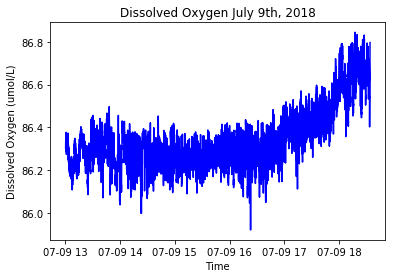

In [10]:
%pylab inline
do = [(d["dissolved_oxygen"],d["time"]) for d in data[-DATA_LIMIT:]]

import pylab as pl
import netCDF4 as nc

pl.title("Dissolved Oxygen July 9th, 2018")
pl.ylabel("Dissolved Oxygen (umol/L)")
pl.xlabel("Time")

x = [nc.num2date(d[1],"seconds since 1900-01-01") for d in do]
y = [d[0] for d in do]

pl.plot(x,y,"-b")

## Updating the Plot

Now, we redraw the plot with each request that gives us new data. For this example we use pylab instead of matplotlib for easier use.

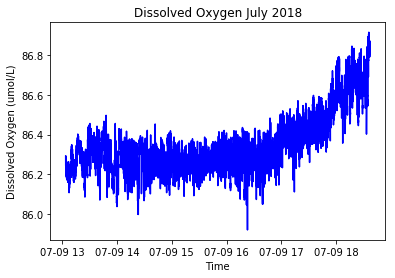

In [11]:
%pylab inline
import time
from IPython import display

# set up figure
x = [nc.num2date(d[1],"seconds since 1900-01-01") for d in do]
y = [d[0] for d in do]

pl.xlabel("Time")
pl.ylabel("Dissolved Oxygen (umol/L)")
pl.title("Dissolved Oxygen July 2018")
pl.plot(x,y)

# shows ten updates
# while True: for infinite loop
for i in range(0,10):
    last_time = nc.num2date(do[-1][1],'seconds since 1900-01-01')
    data = ooi.request_data(
            begin_date = getstr(last_time - datetime.timedelta(seconds = 10)),
            limit = DATA_LIMIT,
            data_type = "json").raw()
    
    # if the request didn't return anything (i.e. data hasn't arrived from the ocean yet)
    if not data[0]:
            print("Nothing found")
            continue
        
    # filter function: if the data point has a time value greater than the last one in do, add it
    else:
        new = list(filter(lambda x: x[1] > do[-1][1], [(d["dissolved_oxygen"],d["time"]) for d in data[0]["data"]]))
        do += new
        # only maintain as many data points as we set out for
        do = do[-DATA_LIMIT:]
        # close old figure
        display.clear_output(wait=True)
        # plot new one
        x = [nc.num2date(d[1],"seconds since 1900-01-01") for d in do]
        y = [d[0] for d in do]
        
        pl.clf()
        pl.ylabel("Dissolved Oxygen (umol/L)")
        pl.xlabel("Time")
        pl.title("Dissolved Oxygen July 2018")
        pl.plot(x,y,"-b")
        display.display(pl.gcf())
        
display.clear_output(wait=True)

Of course, it is difficult to see the plot update with this example because we start with such a large data set. But, over time we should see minor fluctuations. This kind of code can be implemented in a web page or local program to see live updates on instruments such as the CTD.